In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
#multi_periods = [5, 10, 20, 40, 80, 160, 320, 3500, 7000, 14000, 28000, 46000]
multi_periods = [5, 10, 20, 40, 80,  ]
roc_periods = [2, 5, 10]
multiplier = 20
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_CL_cont_non_active_included.pickle')
contract = contract.loc['20190101':'20191231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()

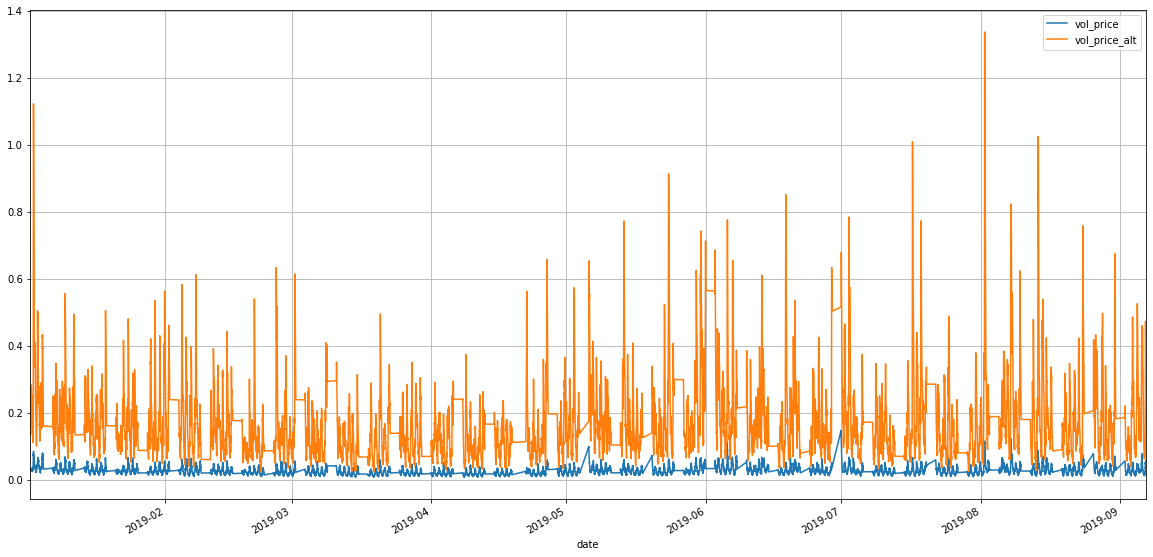

In [5]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

12296.963127791789

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [9]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [10]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def breakout(data, periods, smooth, *args):
    """
    this doesn't belong here
    """
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / data['breakout'].rolling(periods).std()
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [12]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.diff(periods)
    data[f'diff_{periods}'] = data['diff'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vol) for p in roc_periods]).T.mean(axis=1)

In [17]:
forecasts.tail()

,carver,ema,diff
label,,,
7656,-0.211095,-0.107177,-0.197906
7657,-0.205898,-0.155625,-0.179093
7658,-0.177339,-0.191093,-0.151470
7659,-0.146710,-0.211703,-0.109563
7660,-0.117705,-0.221248,-0.071647


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

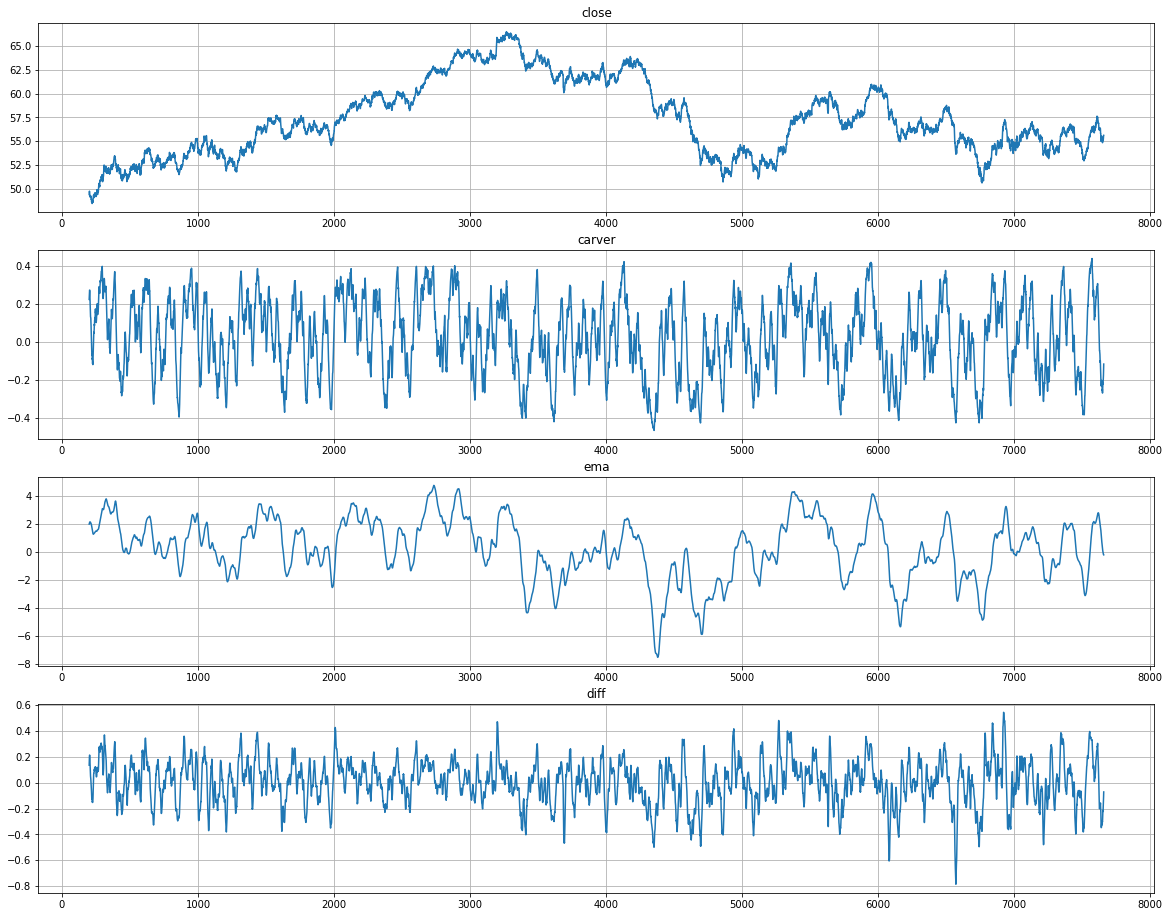

In [19]:
plot(data[['close', 'carver', 'ema', 'diff']])

In [20]:
10 / data[['carver', 'ema', 'diff']].abs().mean()

carver    60.310077
ema        5.760826
diff      75.376970
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 20).clip(lower=-20, upper=20),
                       #'breakout': (data.breakout * 8.7).clip(lower=-20, upper=20),
                       'ema': (data.ema * 5).clip(lower=-20, upper=20),
                       #'diff': (data['diff'] * 3).clip(lower=-20, upper=20)
                      }
                     )

In [22]:
scaled['combined'] = scaled[['carver', 'ema',]].mean(axis=1)

In [23]:
scaled['combined'].std()

6.422696979476402

In [24]:
10 / scaled['combined'].std()

1.5569783273218083

In [25]:
scaled['combined'] = scaled['combined'] *1.7

In [26]:
scaled[['carver', 'ema', ]].corr()

,carver,ema
carver,1.000000,0.586009
ema,0.586009,1.000000


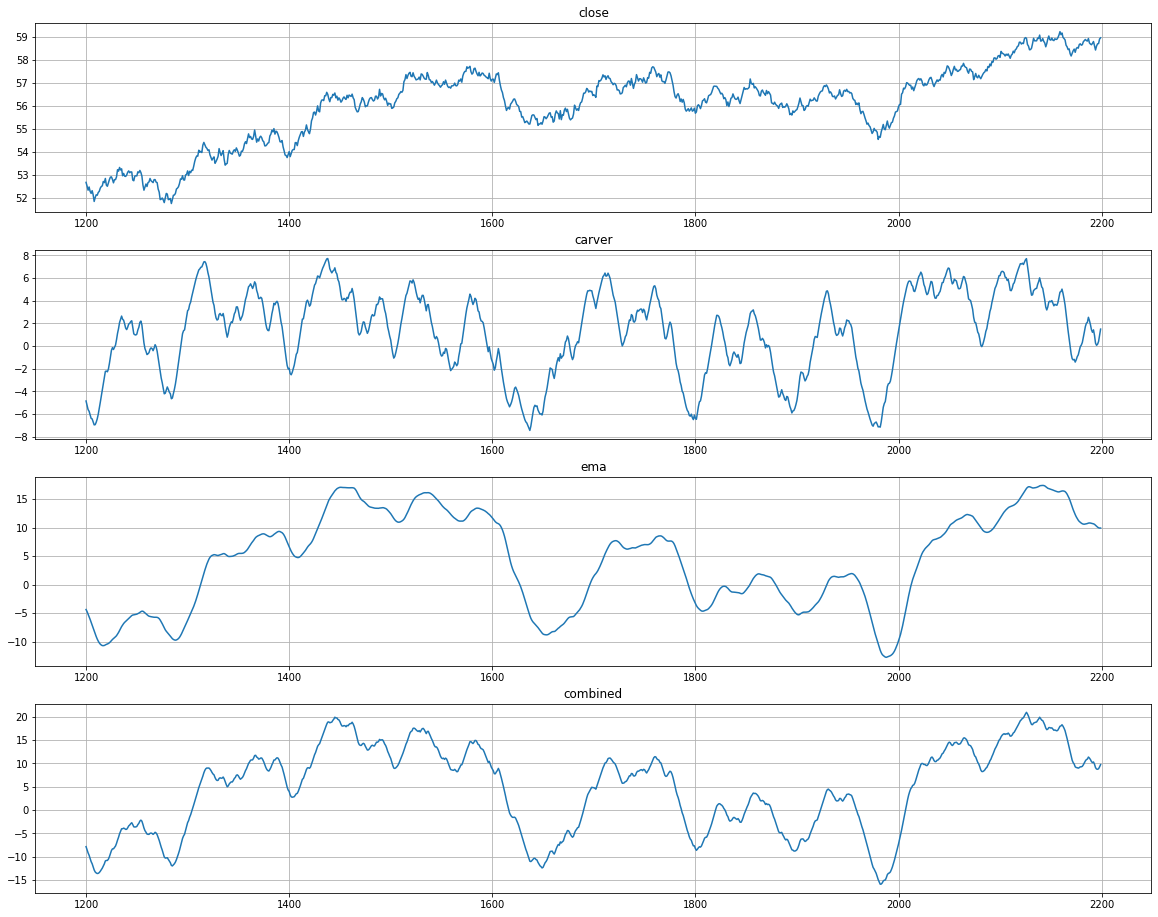

In [27]:
plot(scaled[['close', 'carver', 'ema', 'combined']].iloc[1000:2000])

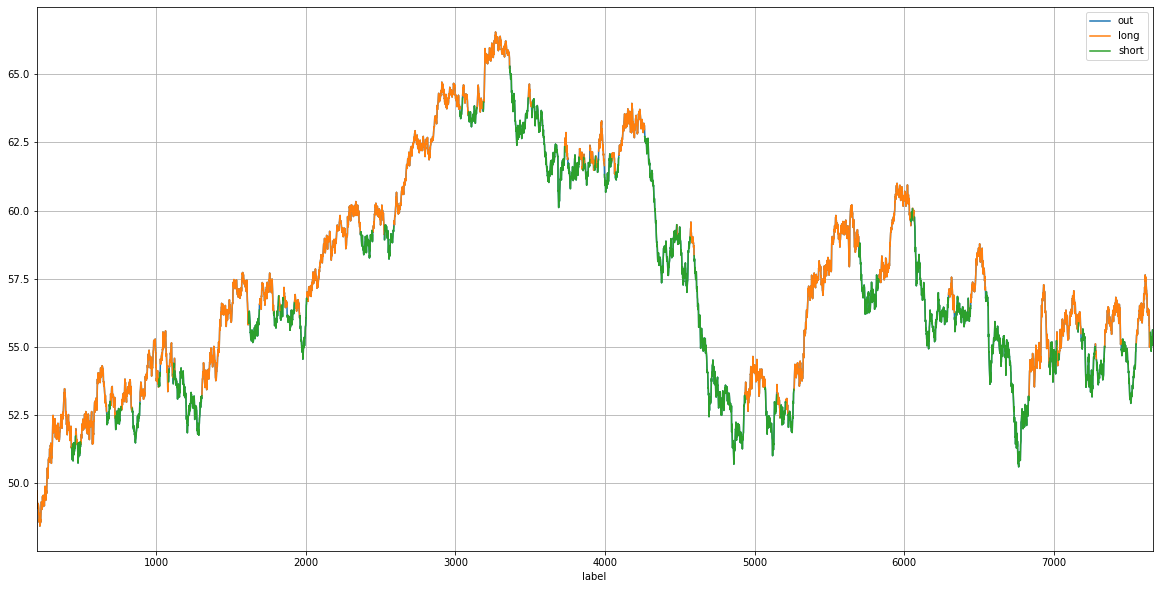

In [28]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 0);

In [29]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, ]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [30]:
stats

,0,1,2,3,4,5,6,7,8,10,15
Annual return,0.162424,0.224156,0.158465,-0.00988591,0.129051,0.107967,0.124222,-0.000291185,0.0128374,0.0563779,0.0260175
Cumulative returns,0.11084,0.151719,0.108196,-0.00691479,0.0884686,0.0742323,0.0852146,-0.000203376,0.00894855,0.0390482,0.0181005
Annual volatility,0.350349,0.315604,0.316294,0.334502,0.29801,0.286643,0.276726,0.281367,0.252752,0.208084,0.166446
Sharpe ratio,0.602787,0.796847,0.620897,0.134374,0.553653,0.498013,0.558364,0.136355,0.17397,0.365222,0.235263
Calmar ratio,0.741742,1.65838,0.991683,-0.0435146,0.850297,0.614346,0.74809,-0.00142265,0.0766811,0.484756,0.254299
Stability,0.341239,0.677467,0.561166,0.145469,0.529386,0.427922,0.385439,0.088909,0.237594,0.463594,0.485806
Max drawdown,-0.218977,-0.135166,-0.159794,-0.227186,-0.151772,-0.175744,-0.166052,-0.204677,-0.167413,-0.116302,-0.102311
Omega ratio,1.10776,1.14405,1.10878,1.02261,1.09939,1.09072,1.10894,1.02626,1.03464,1.08612,1.07621
Sortino ratio,0.93081,1.2787,1.01907,0.223202,0.943919,0.89062,1.02822,0.243239,0.311765,0.682182,0.46657
Skew,0.441383,0.539317,0.740188,1.00973,1.0384,1.33903,1.56078,1.58999,1.69767,2.10811,3.27971


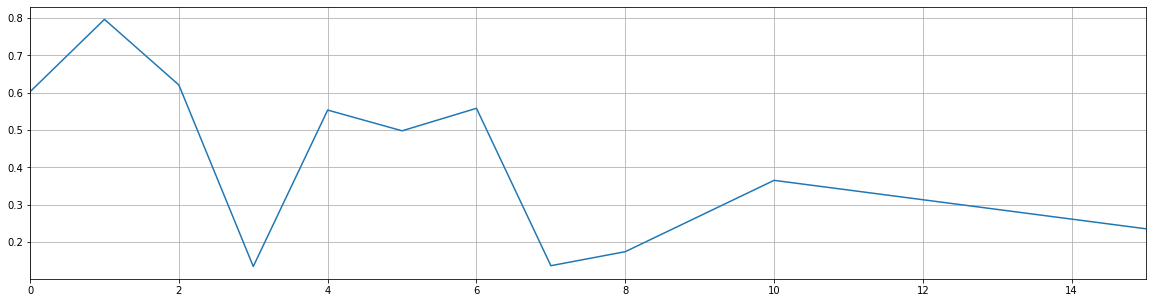

In [31]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

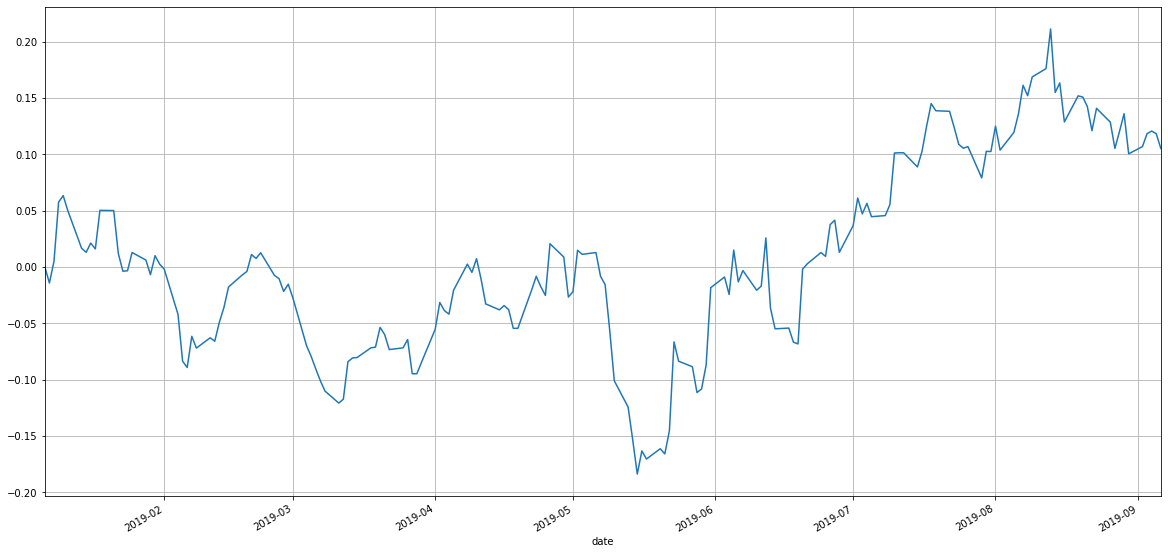

In [33]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);